<a id="TMP_7090"></a>

# <span style="color:rgb(213,80,0)">Normalizing images by CSF and WM covariates</span>

This live script explains how normalize\_gm\_by\_wm\_csf reduces image\-wide zero\-point shifts and scaling differences by modeling gray matter intensities as a function of global white matter and CSF values. This can improve sensitivity in second\-level analyses by removing global nuisance variance before group modeling (including mixed effects analyses with fitlme\_voxelwise).

<!-- Begin Toc -->

## Table of Contents
&#8195;[Why normalize using WM and CSF](#TMP_6766)

&#8195;[Check for global GM, WM, and CSF shifts](#TMP_7124)

&#8195;[Normalize GM using WM and CSF covariates](#TMP_500a)

&#8195;&#8195;[Interpreting the comparison](#TMP_1b7b)

&#8195;[Link to voxelwise mixed effects models](#TMP_2f2e)

<!-- End Toc -->
<a id="TMP_6766"></a>

## Why normalize using WM and CSF

Global shifts in gray matter can arise from scanner drift, acquisition differences, or preprocessing artifacts. By estimating subject\-level additive shifts (from CSF and WM medians) and multiplicative scaling (from GM, WM, and CSF MADs), normalize\_gm\_by\_wm\_csf aligns global intensity distributions across subjects without changing spatial patterns within gray matter.

This normalization is especially helpful when you plan to compare group\-level maps or fit second\-level models, because it reduces between\-subject variance unrelated to neural signal. The normalized images can then be analyzed with standard t\-tests or with voxelwise mixed effects models such as fitlme\_voxelwise.

<a id="TMP_7124"></a>

## Check for global GM, WM, and CSF shifts

First, extract global summaries from gray matter, white matter, and CSF to assess image\-wide shifts.


In [1]:
% Load example data
imgs = load_image_set('emotionreg');

Loaded images:
/Users/f003vz1/Documents/GitHub/CanlabCore/CanlabCore/Sample_datasets/Wager_et_al_2008_Neuron_EmotionReg/Wager_2008_emo_reg_vs_look_neg_contrast_images.nii
/Users/f003vz1/Documents/GitHub/CanlabCore/CanlabCore/Sample_datasets/Wager_et_al_2008_Neuron_EmotionReg/Wager_2008_emo_reg_vs_look_neg_contrast_images.nii
/Users/f003vz1/Documents/GitHub/CanlabCore/CanlabCore/Sample_datasets/Wager_et_al_2008_Neuron_EmotionReg/Wager_2008_emo_reg_vs_look_neg_contrast_images.nii
/Users/f003vz1/Documents/GitHub/CanlabCore/CanlabCore/Sample_datasets/Wager_et_al_2008_Neuron_EmotionReg/Wager_2008_emo_reg_vs_look_neg_contrast_images.nii
/Users/f003vz1/Documents/GitHub/CanlabCore/CanlabCore/Sample_datasets/Wager_et_al_2008_Neuron_EmotionReg/Wager_2008_emo_reg_vs_look_neg_contrast_images.nii
/Users/f003vz1/Documents/GitHub/CanlabCore/CanlabCore/Sample_datasets/Wager_et_al_2008_Neuron_EmotionReg/Wager_2008_emo_reg_vs_look_neg_contrast_images.nii
/Users/f003vz1/Documents/GitHub/CanlabCore/Canlab

In [2]:


% Extract mean GM, WM, and CSF values for each image
% values is N_images x 3 for GM, WM, and CSF
[values, components] = extract_gray_white_csf(imgs);

Extracting from gray_matter_mask_sparse.img.
Extracting from canonical_white_matter.img.
Extracting from canonical_ventricles.img.


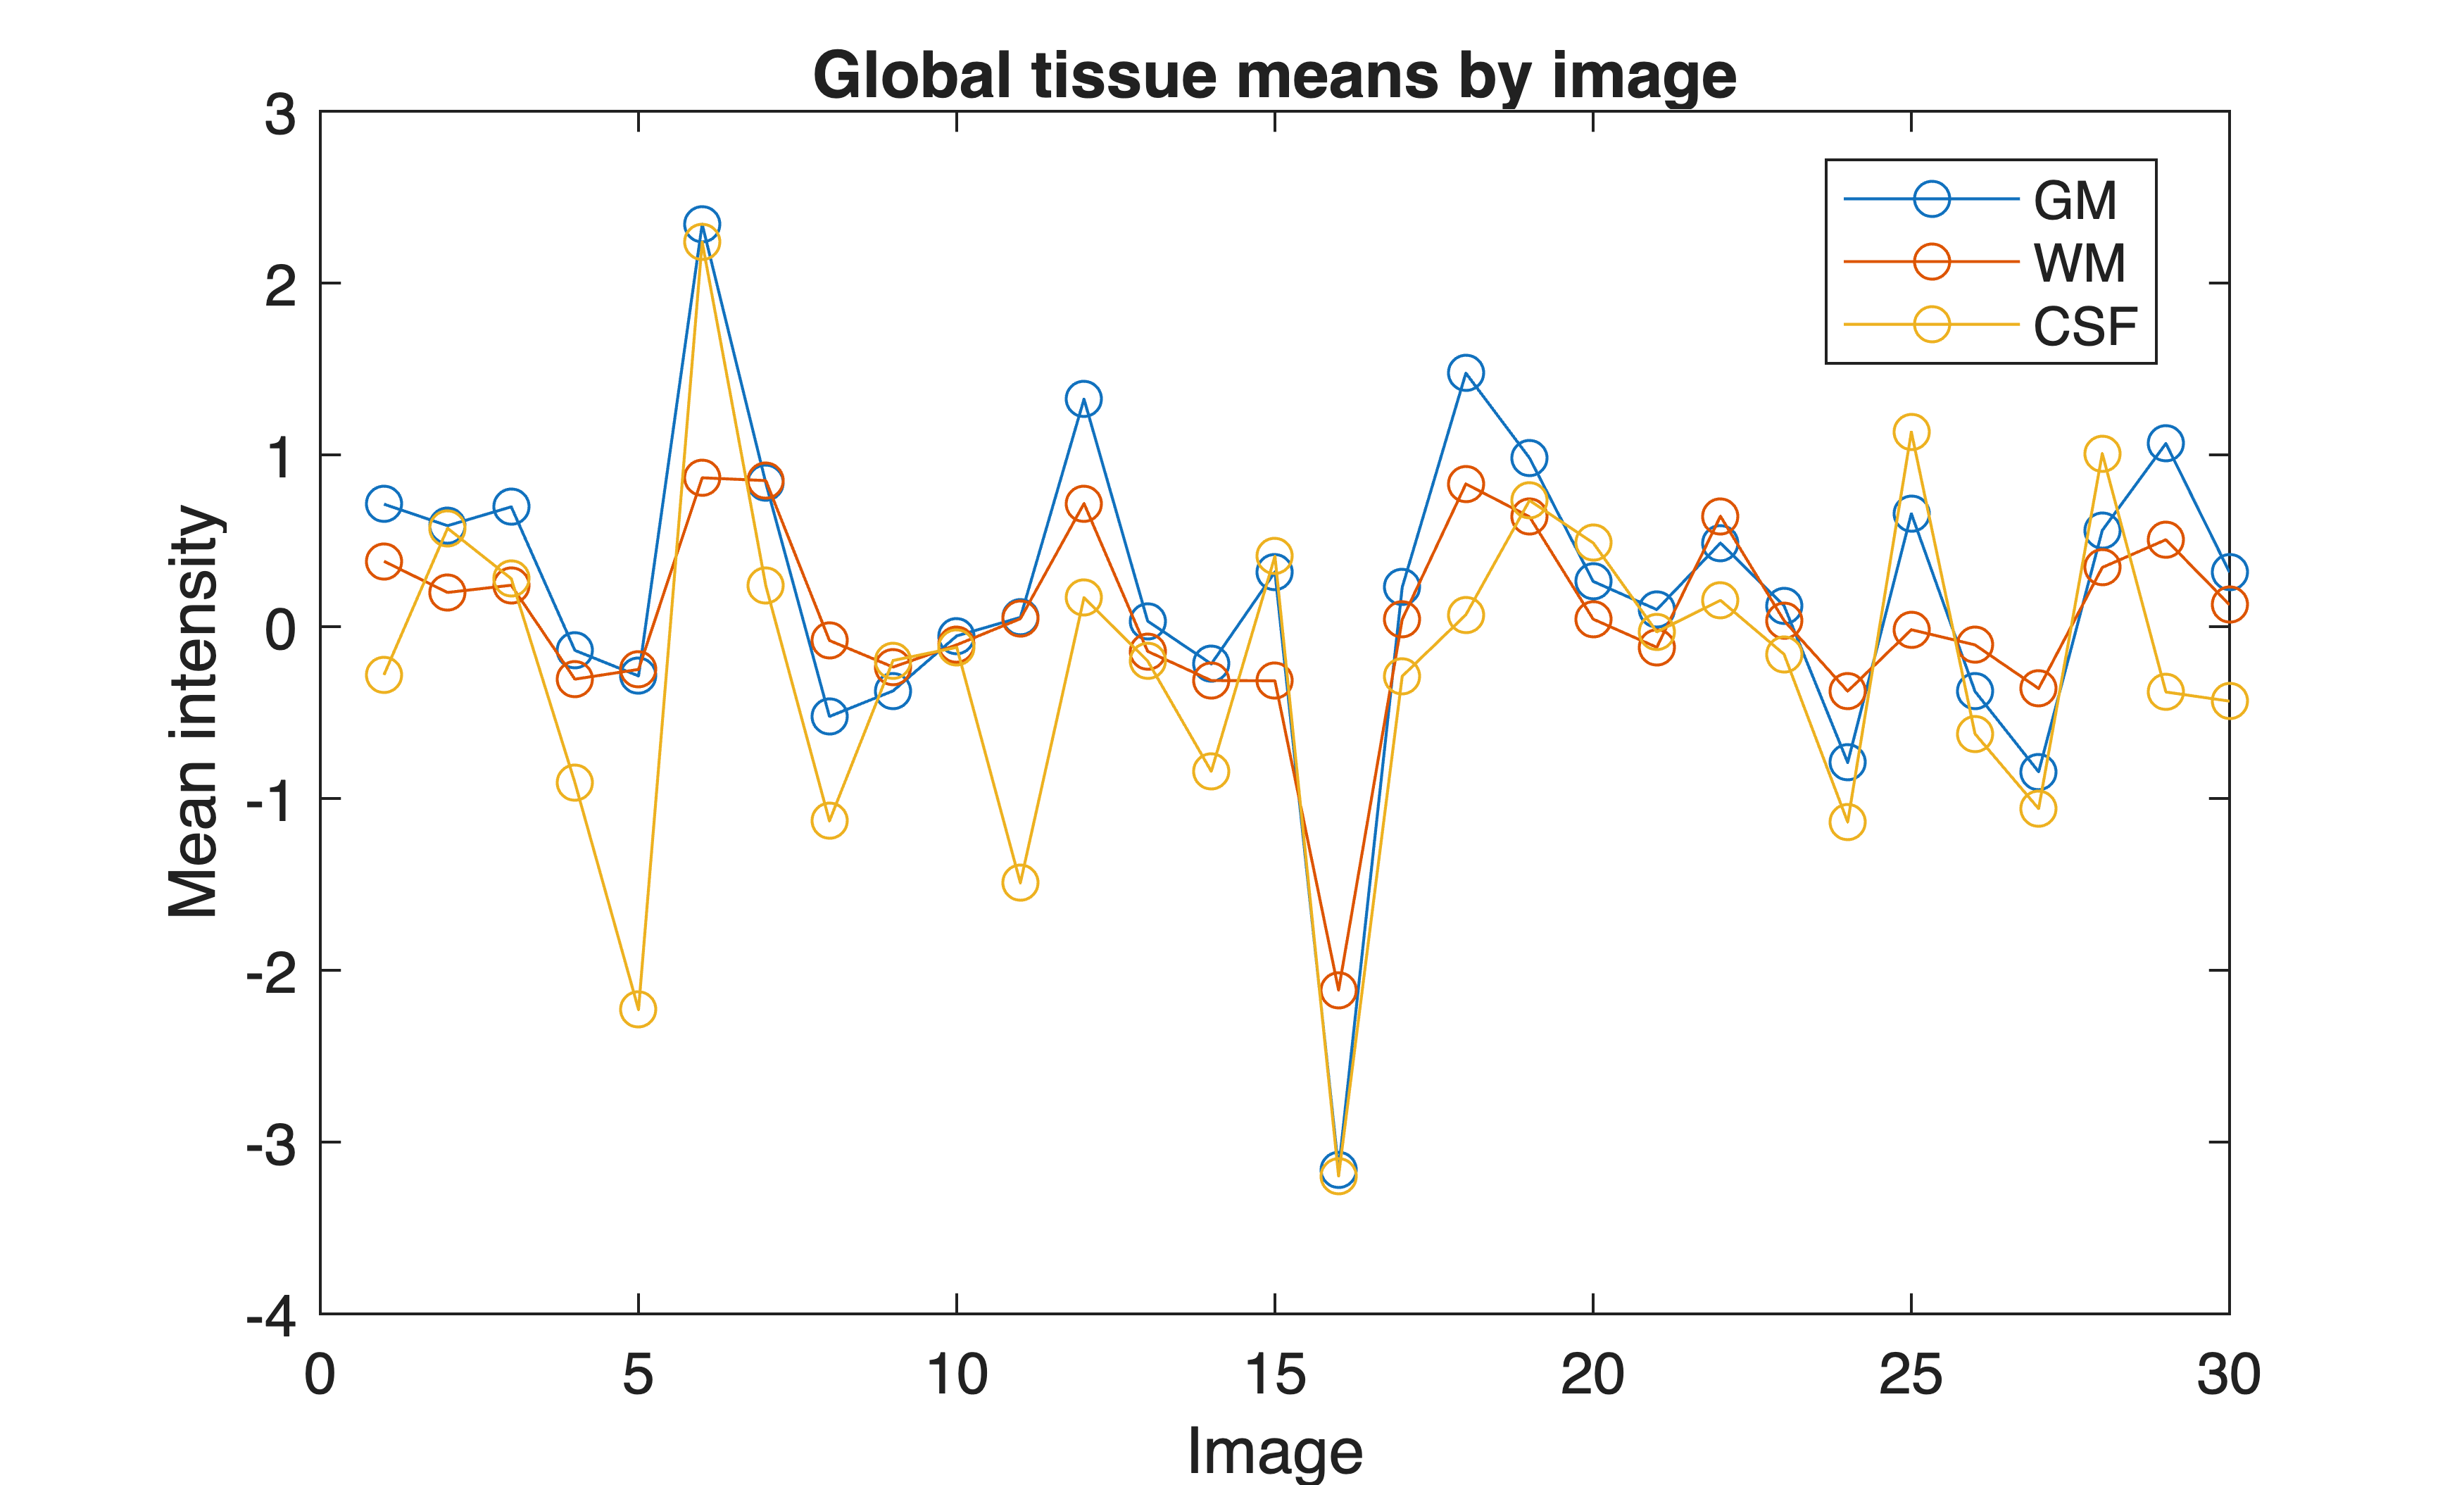

In [3]:


% Quick diagnostic plot of tissue means
figure; plot(values, 'o-');
legend({'GM', 'WM', 'CSF'}, 'Location', 'best');
xlabel('Image'); ylabel('Mean intensity');
title('Global tissue means by image');


The values matrix reports one mean per tissue class for each image. Large offsets or scaling differences across images indicate global shifts that can inflate between\-subject variance in group\-level analyses.

The components output contains the top five components within each tissue class and can be used to diagnose structured noise. For normalization, the key signal is in the global GM, WM, and CSF summaries.

<a id="TMP_500a"></a>

## Normalize GM using WM and CSF covariates

Run normalization and compare the statistical results before and after.


In [4]:
% T-test on un-normalized data
t = ttest(imgs);

One-sample t-test
Calculating t-statistics and p-values


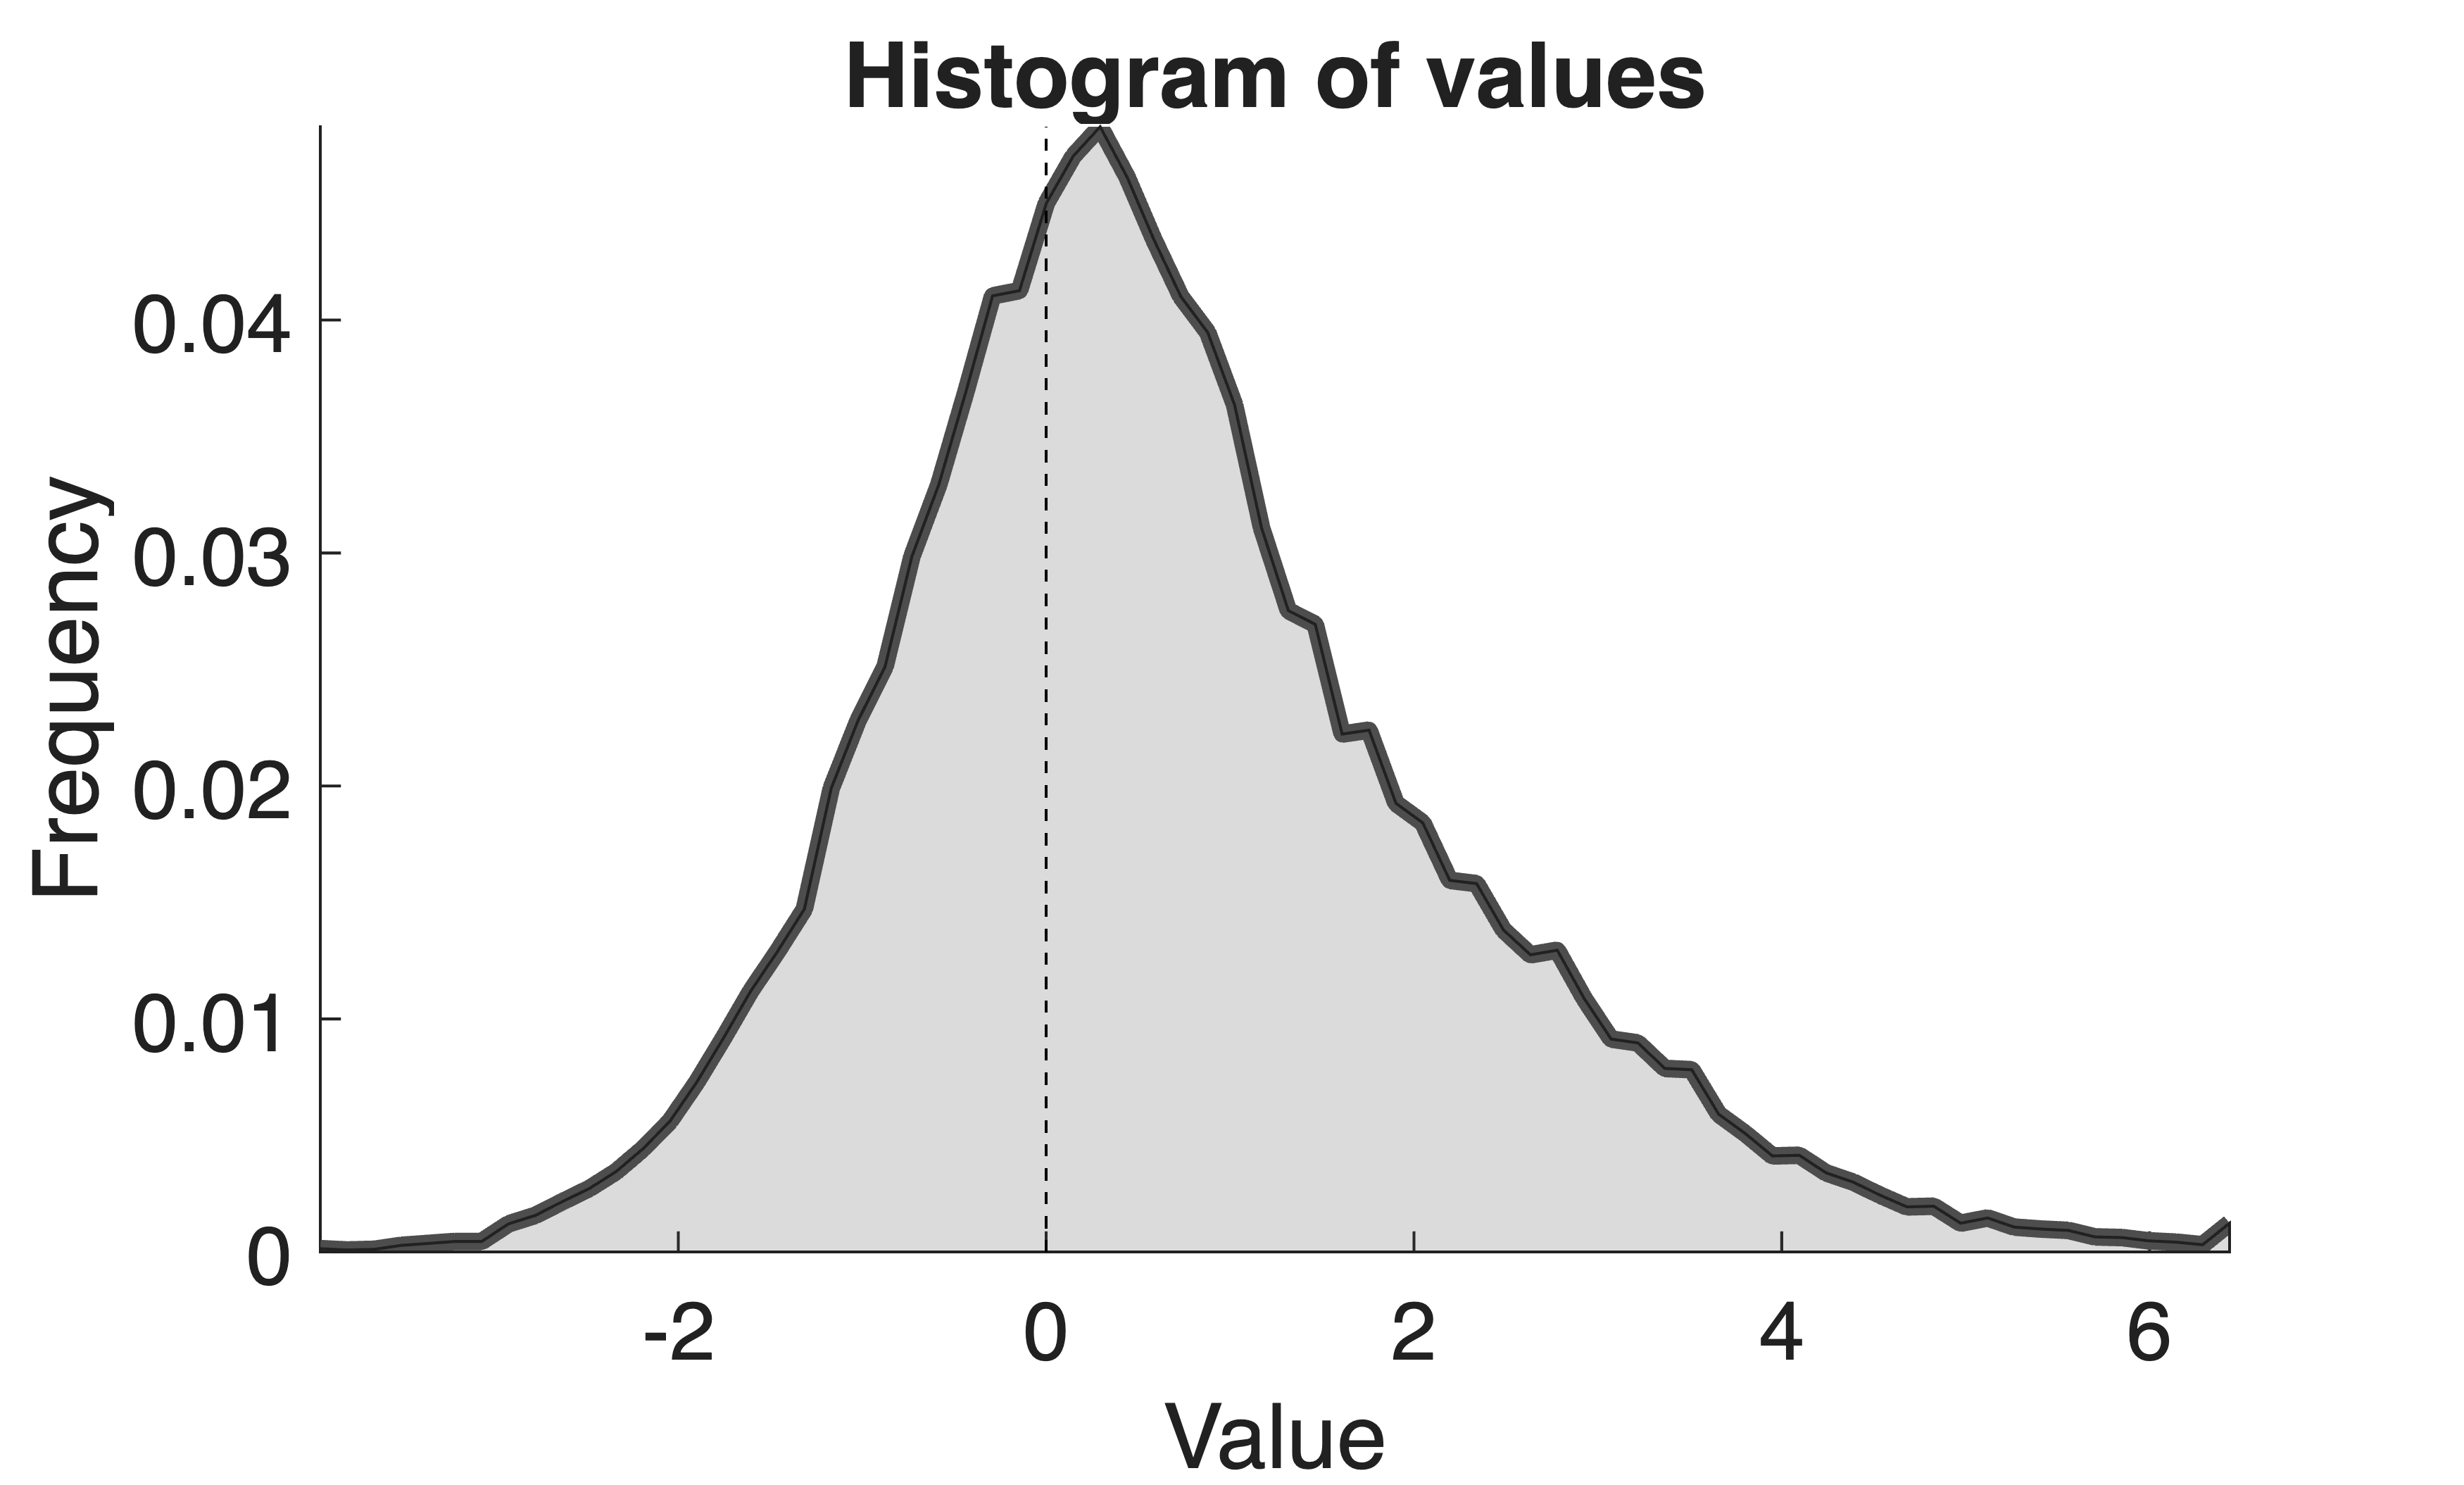

In [5]:
histogram(t);

In [6]:
set(gcf, 'Tag', 'unnormalized');


% Normalize and re-run t-test
imgs_normalized = normalize_gm_by_wm_csf(imgs);

Using default mask: /Users/f003vz1/Documents/GitHub/CanlabCore/CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_canlab.nii
iimg_get_data: loading mask. mapping volumes. 
checking that dimensions and voxel sizes of volumes are the same. 
Pre-allocating data array. Needed: 971812 bytes
Loading image number:     1
Elapsed time is 0.009104 seconds.
Number of unique values in dataset: 19483  Bit rate: 14.25 bits
Using default mask: /Users/f003vz1/Documents/GitHub/CanlabCore/CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_canlab.nii
iimg_get_data: loading mask. mapping volumes. 
checking that dimensions and voxel sizes of volumes are the same. 
Pre-allocating data array. Needed: 971812 bytes
Loading image number:     1
Elapsed time is 0.008930 seconds.
Number of unique values in dataset: 438  Bit rate: 8.77 bits
Using default mask: /Users/f003vz1/Documents/GitHub/CanlabCore/CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_can

In [7]:
t2 = ttest(imgs_normalized);

One-sample t-test
Calculating t-statistics and p-values


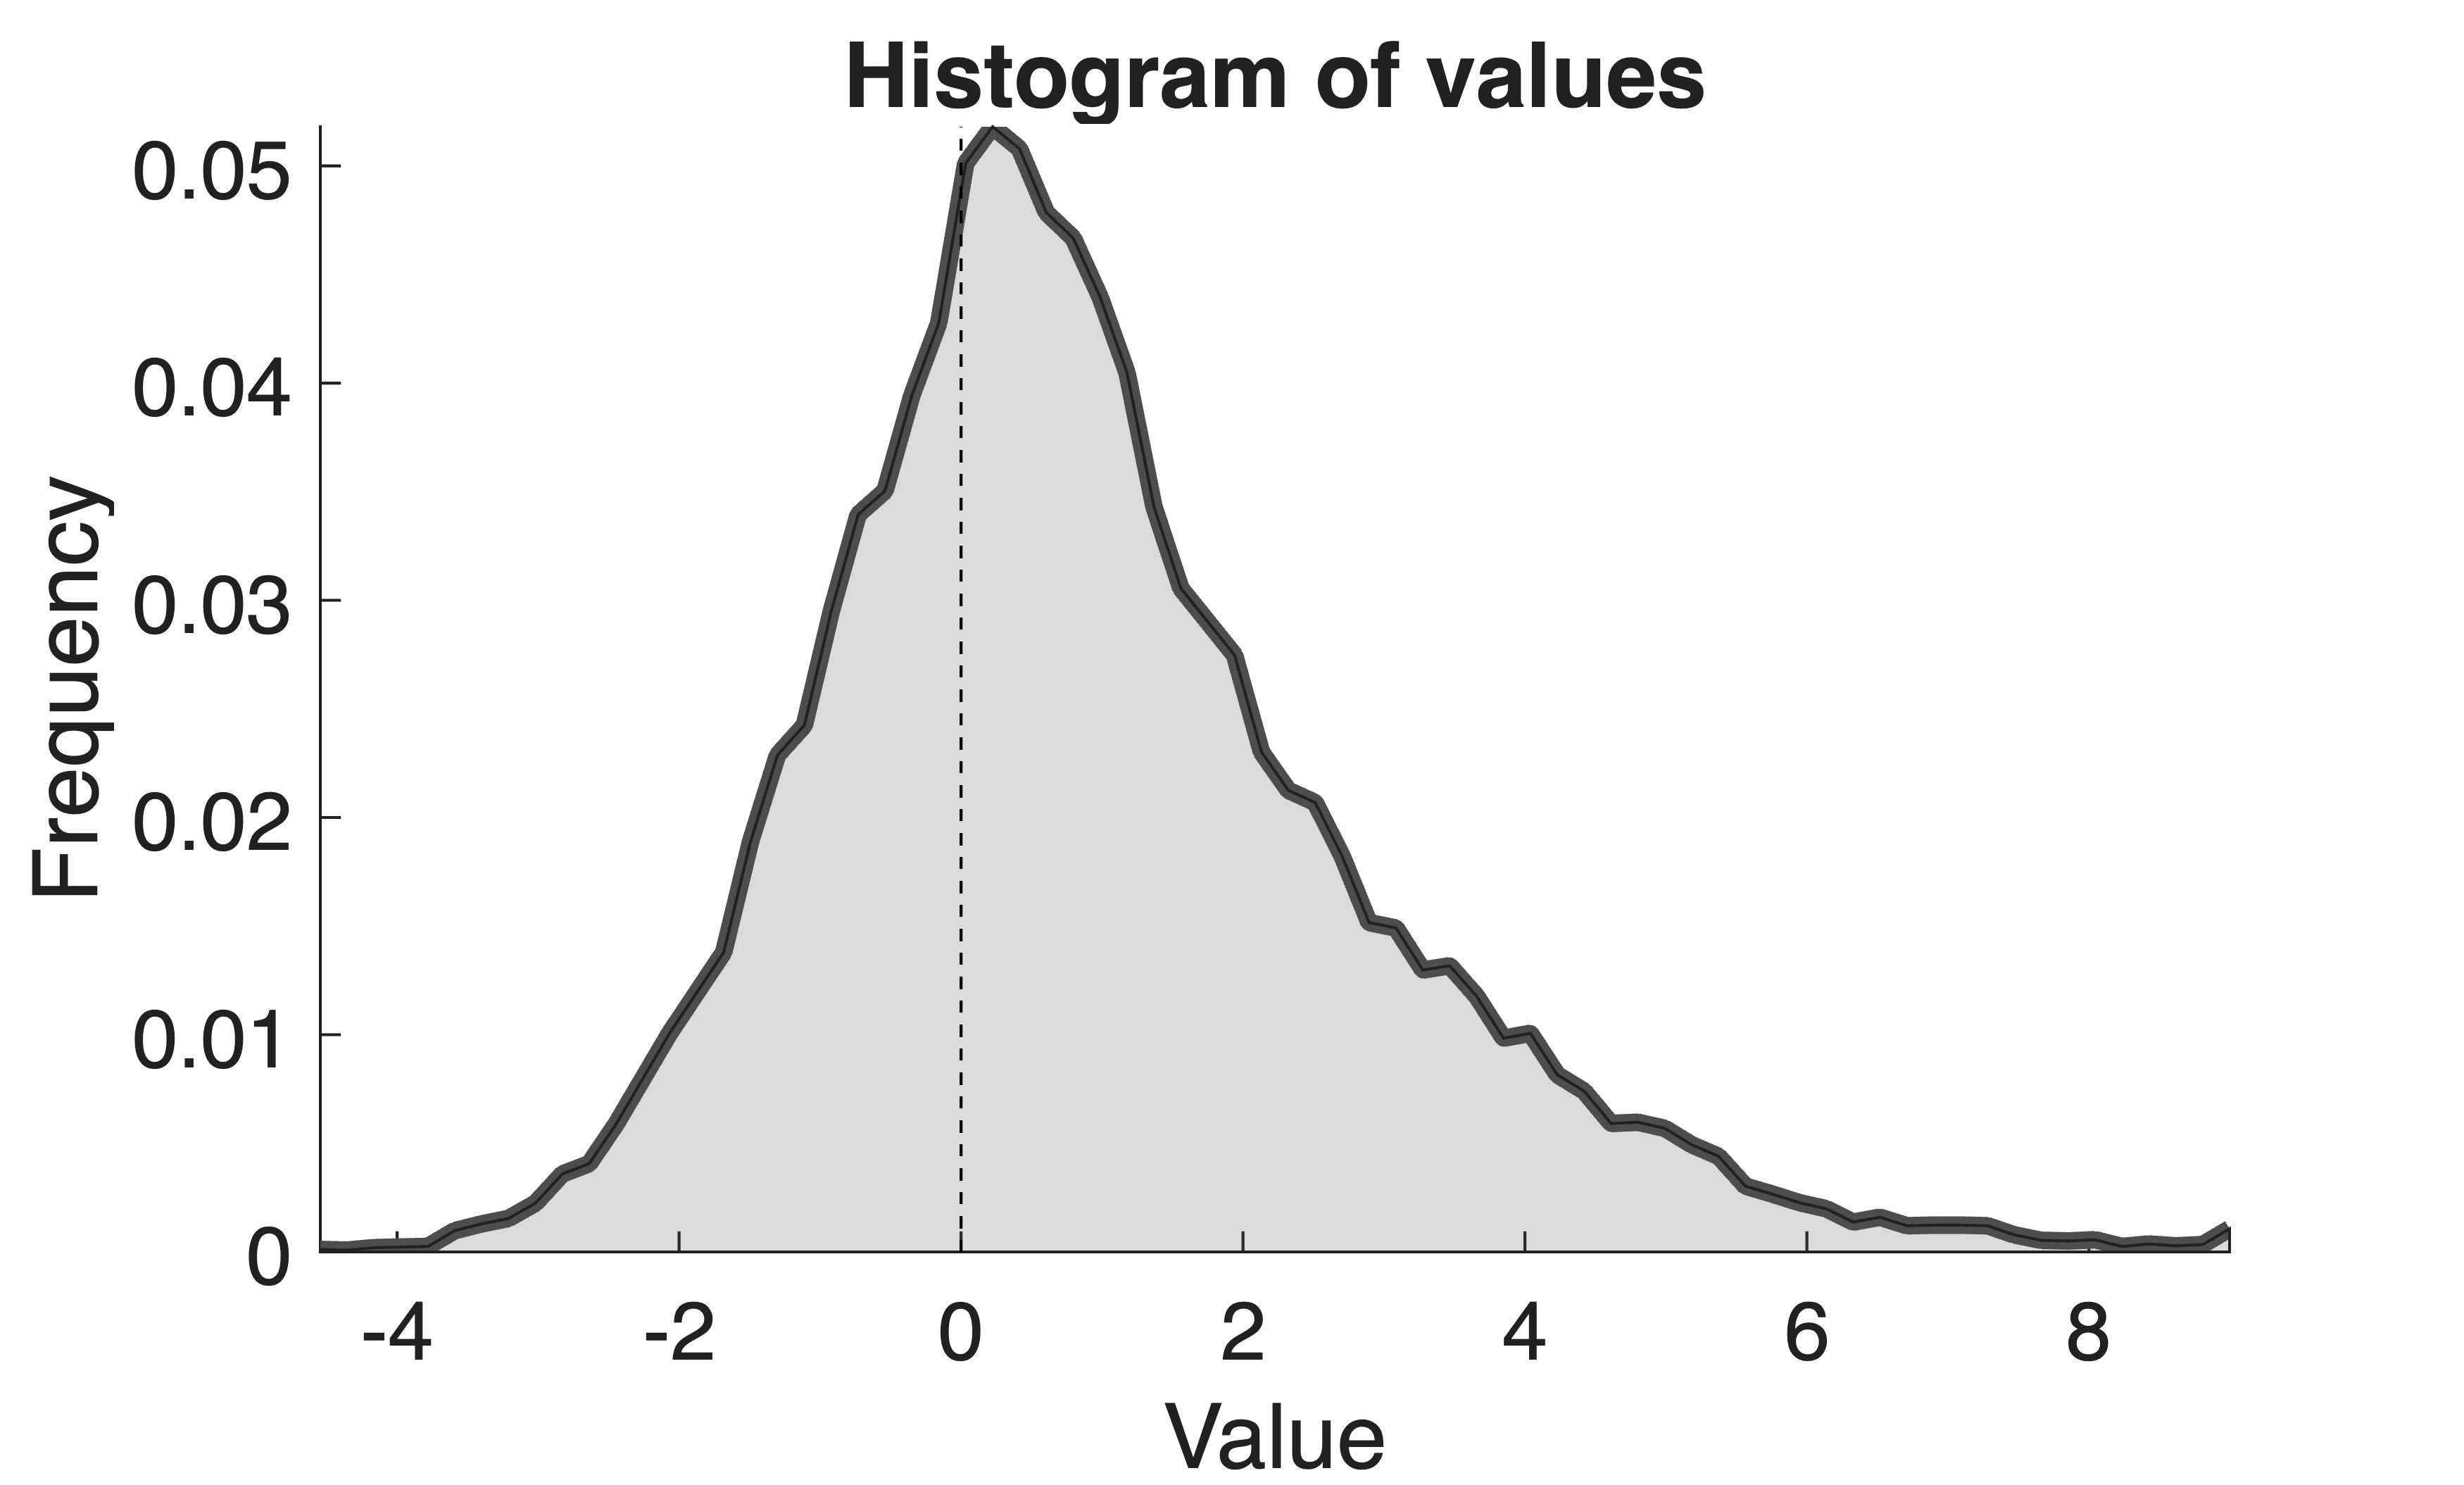

In [8]:
histogram(t2);


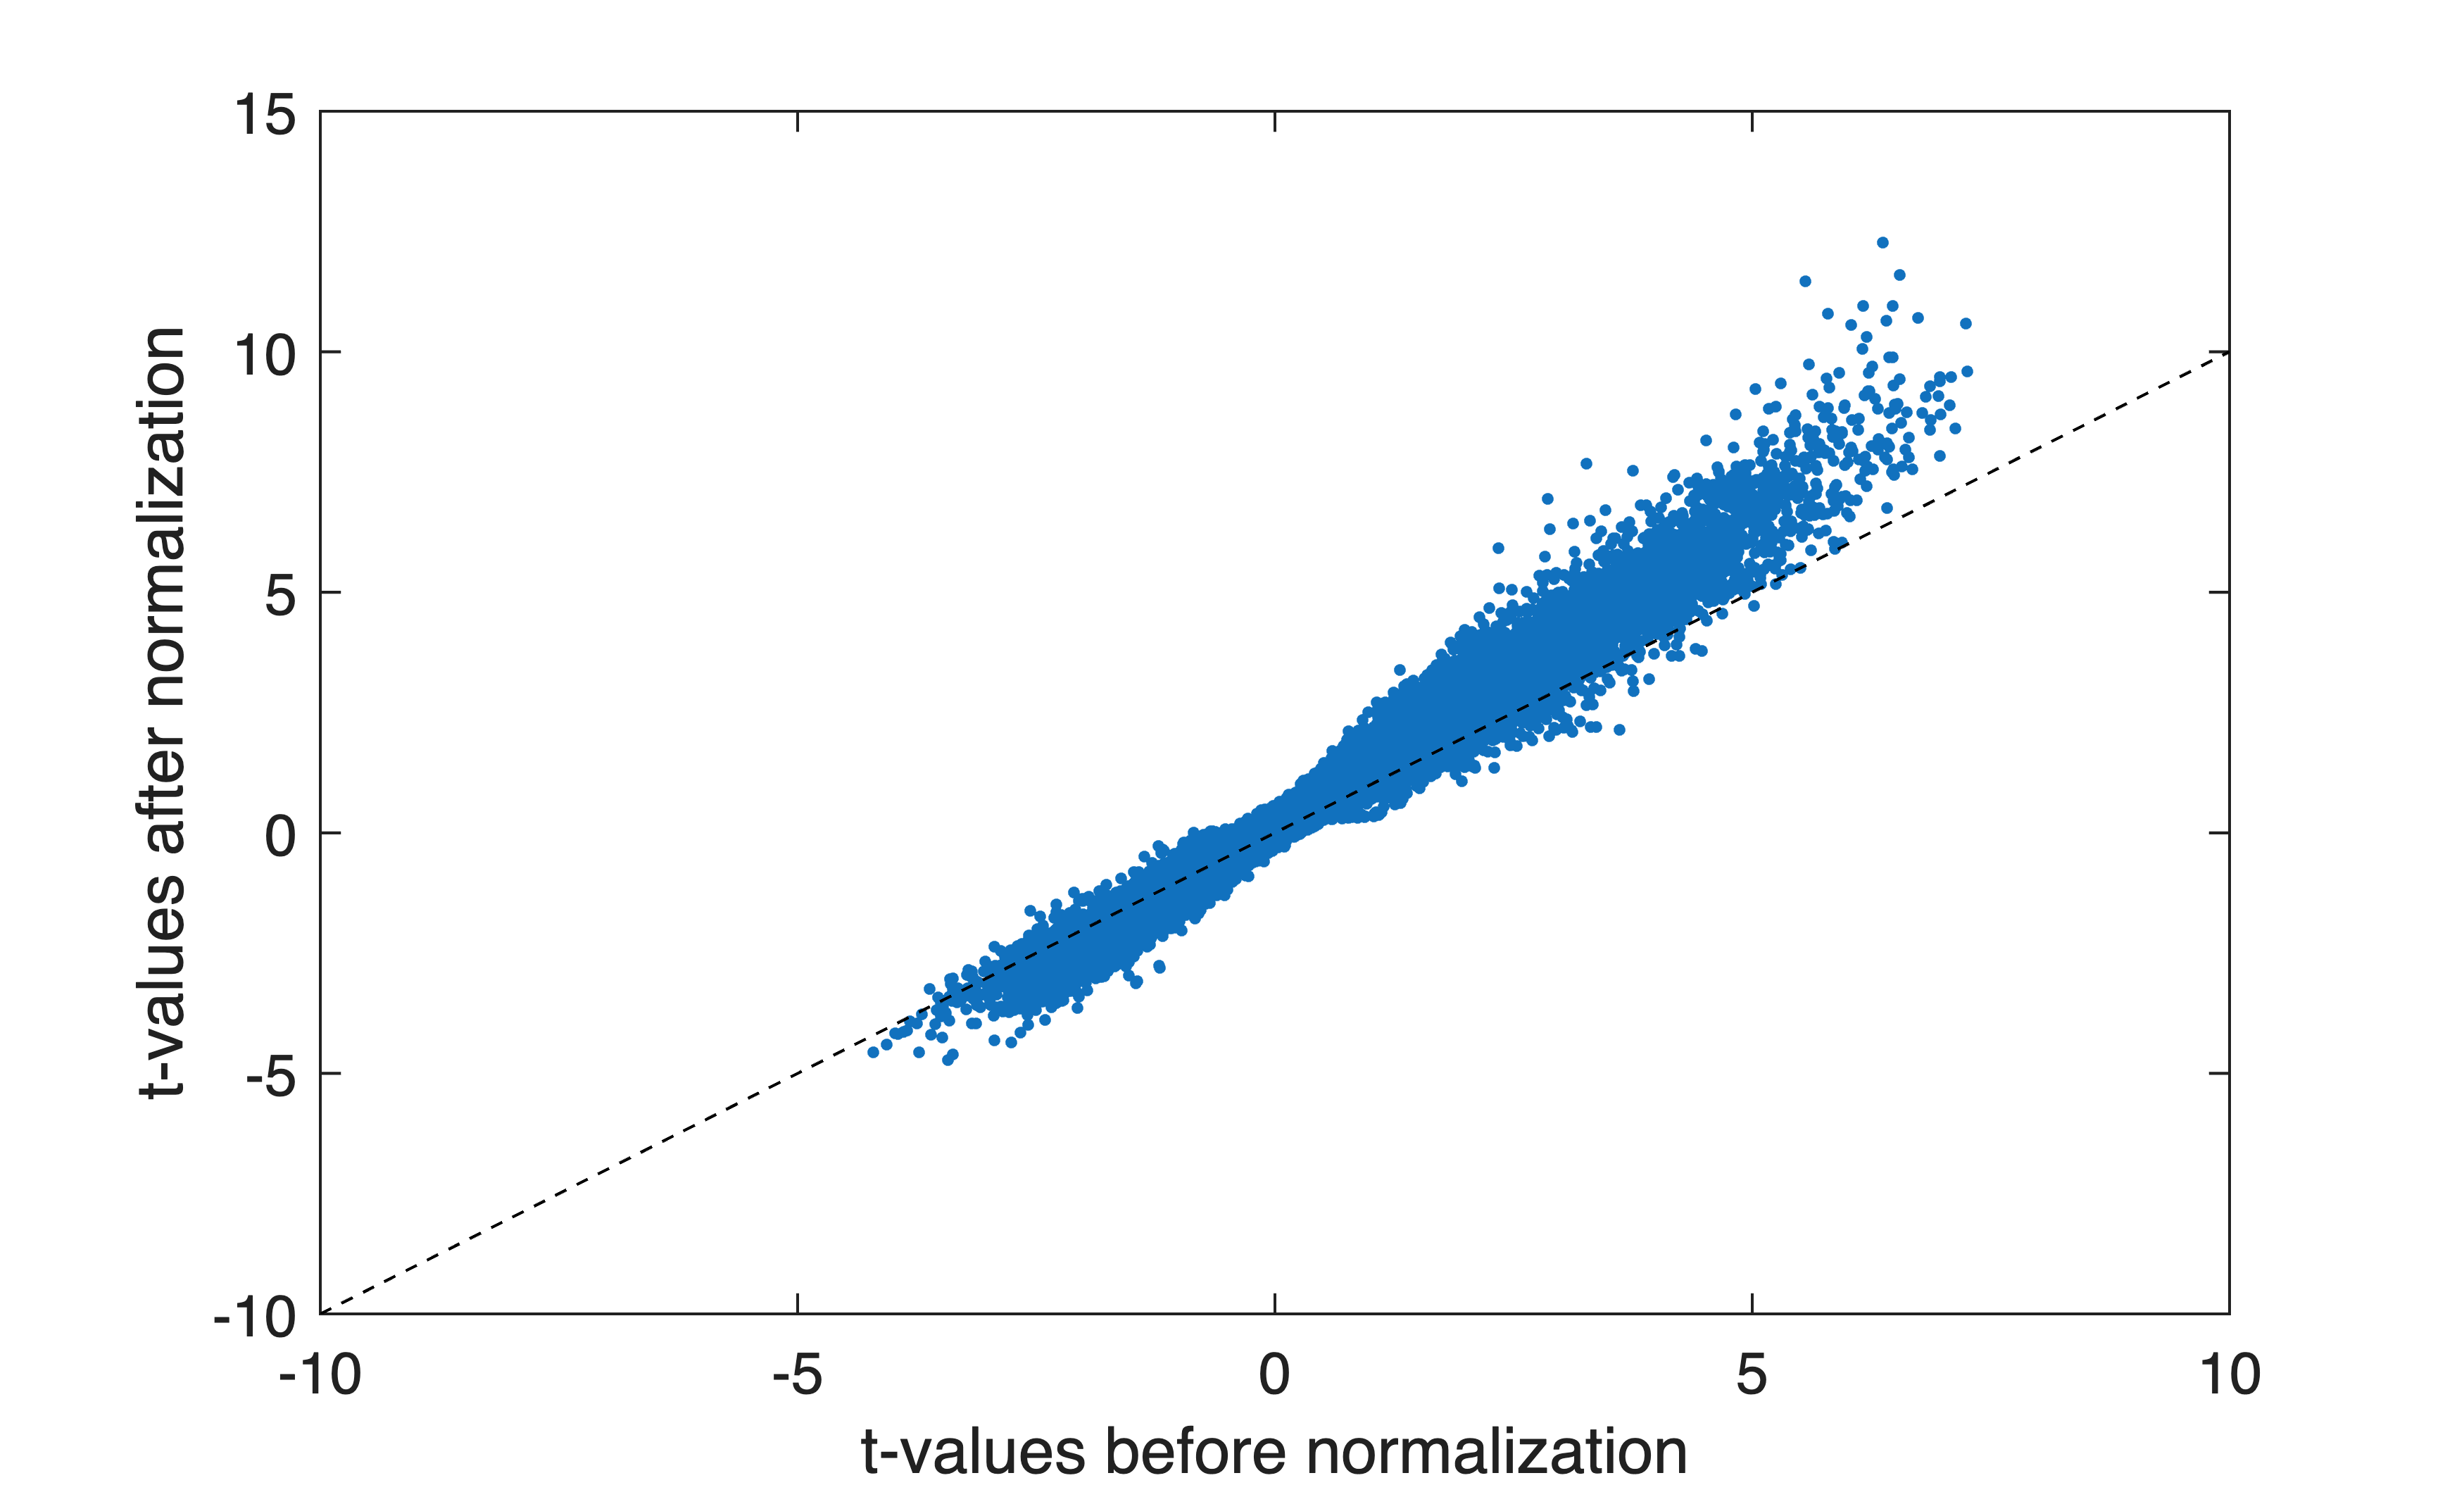

In [9]:
% Compare the t-values
figure; plot(t.dat, t2.dat, '.');
hold on; plot([-10 10], [-10 10], '--', 'Color', 'k');
xlabel('t-values before normalization'); ylabel('t-values after normalization');


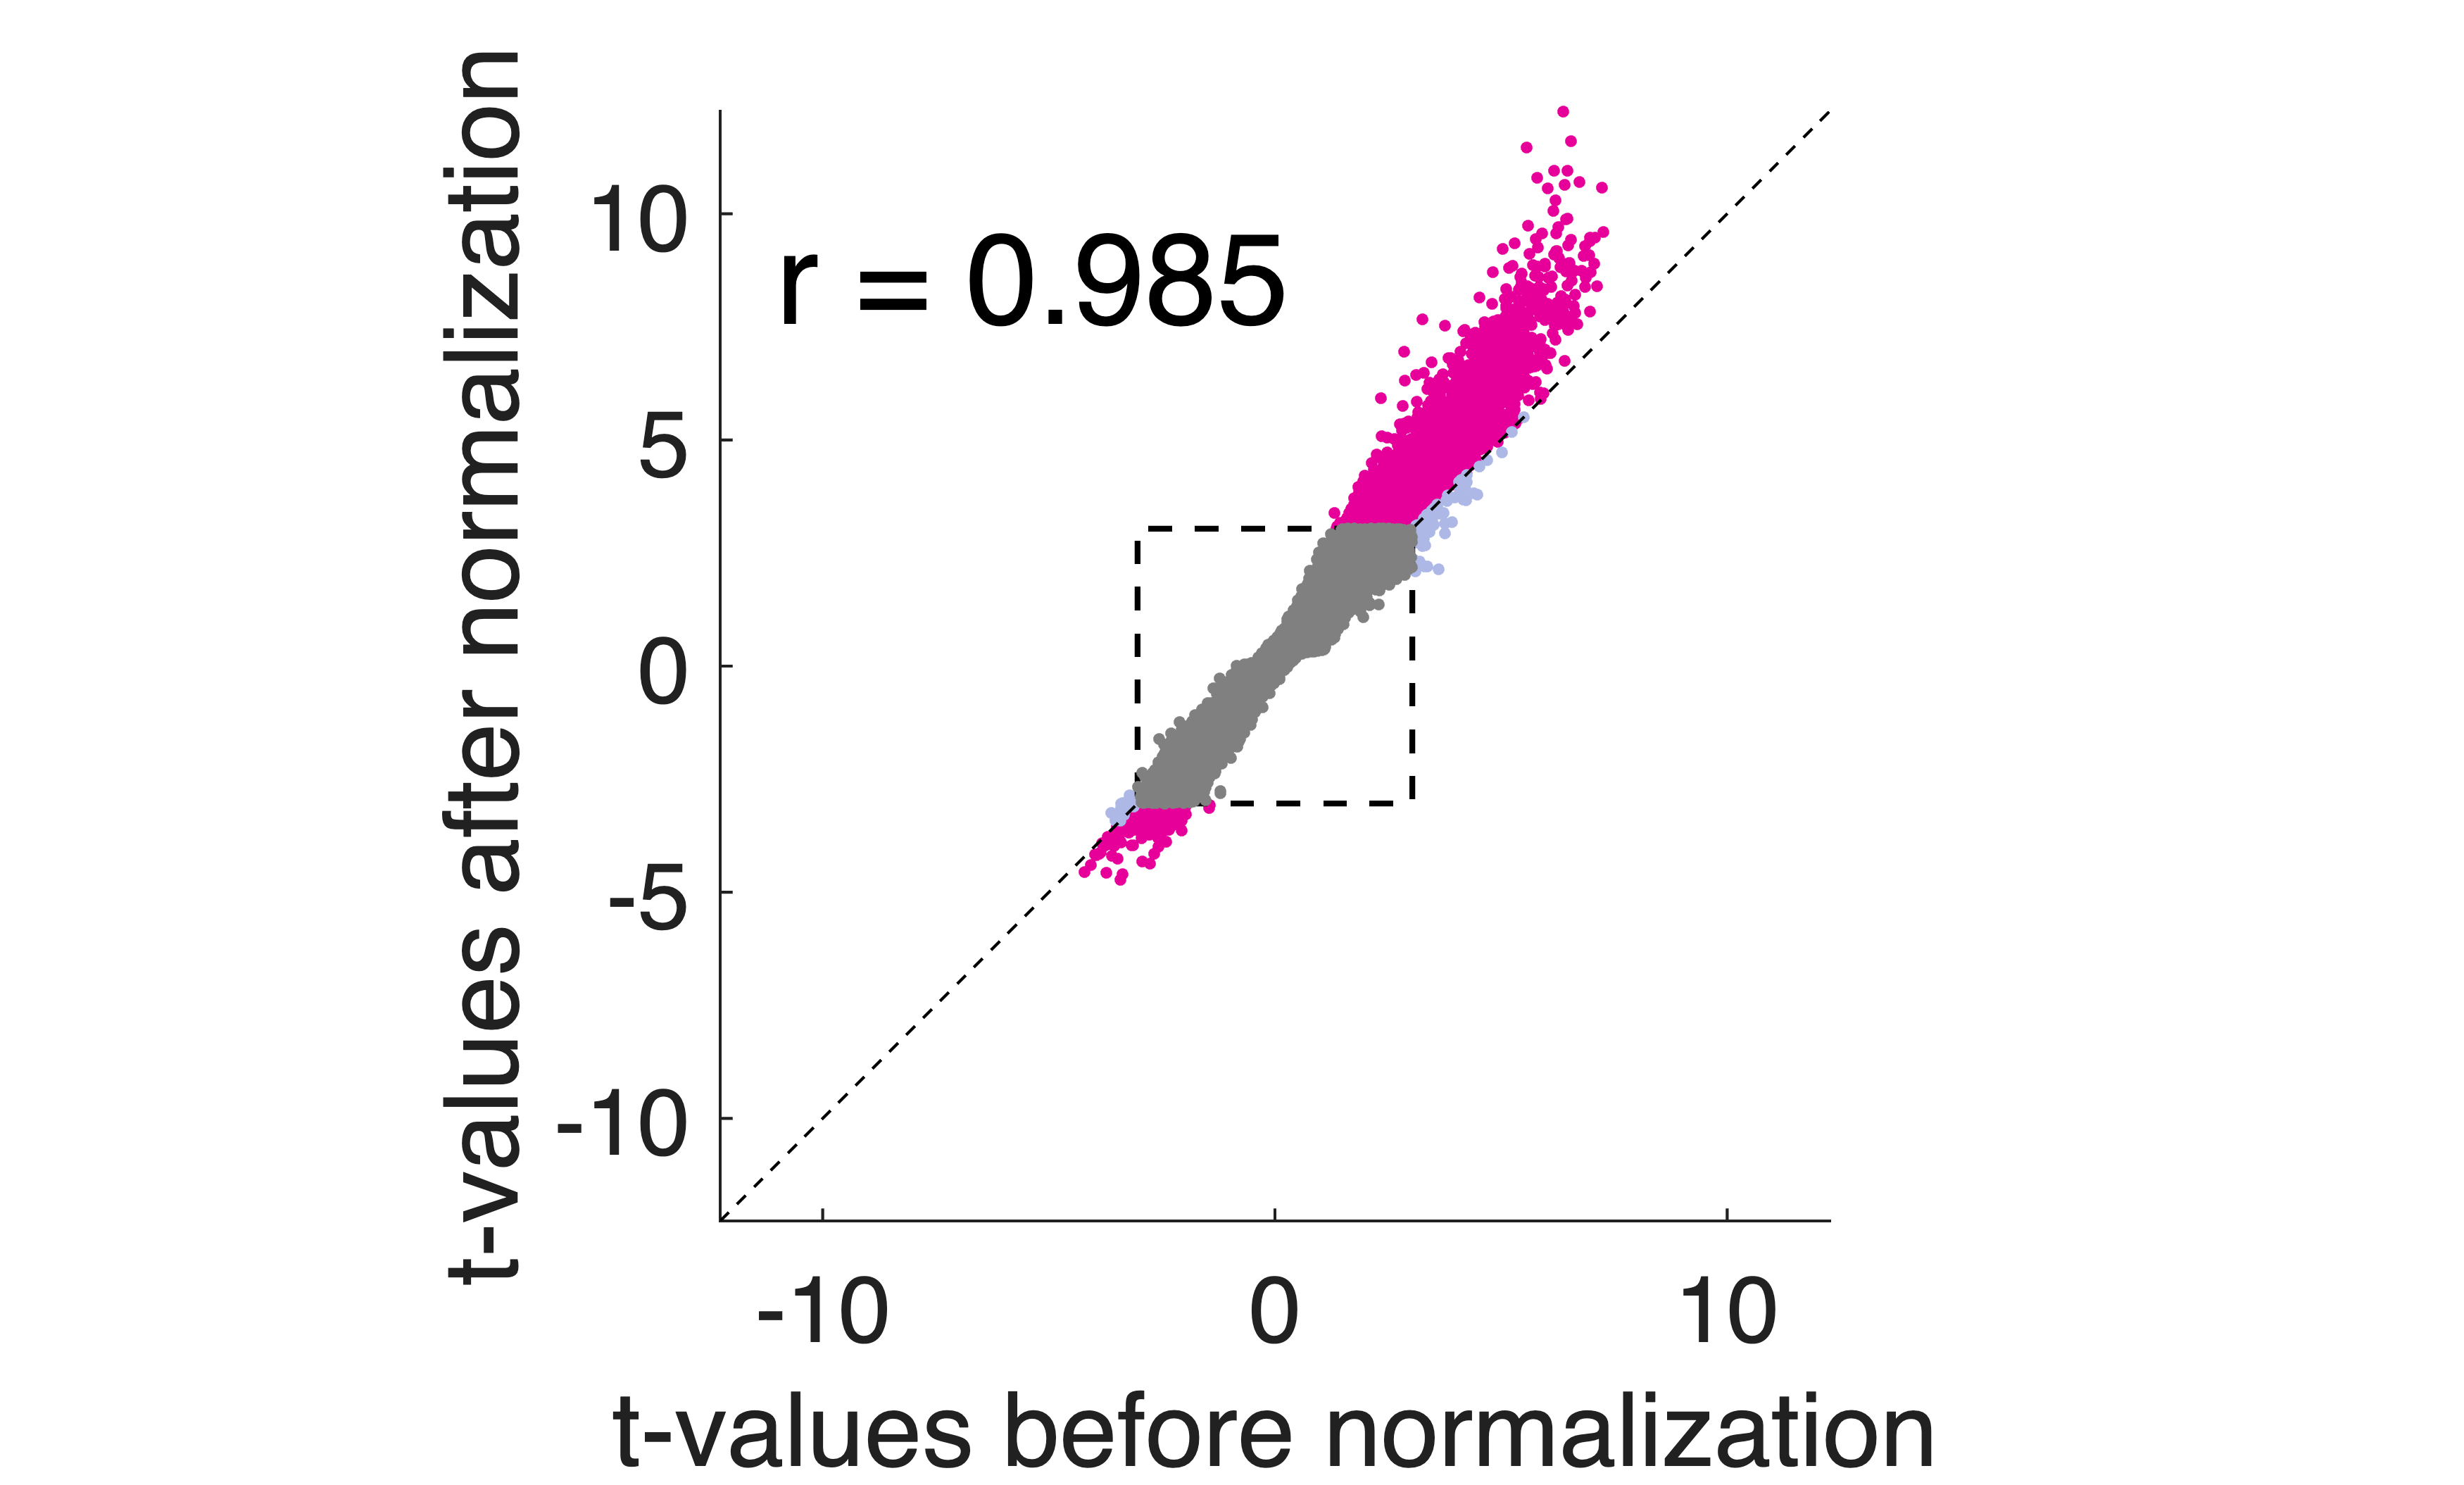

In [10]:
% or:
h = image_scatterplot(t, t2, 'pvaluebox', 0.005, 'colorpoints');
xlabel('t-values before normalization'); ylabel('t-values after normalization');
set(gca, 'FontSize', 16)

<a id="TMP_1b7b"></a>

### Interpreting the comparison

In the scatterplot comparison, points above the diagonal indicate voxels with larger t\-values after normalization. When using image\_scatterplot with colorpoints, colored points indicate voxels that are significant in both maps. Blue points are those that become significant or show stronger effects before normalization, while pink points indicate voxels that become significant or show stronger effects after normalization. In this example, pink points highlight voxels where statistical sensitivity and power improve after removing global shifts and scaling differences.

<a id="TMP_2f2e"></a>

## Link to voxelwise mixed effects models

After normalization, you can pass the normalized fmri\_data object into fmri\_data.regress(),  fmri\_data.fitlme\_voxelwise(), or similar tools for  statistical GLM modeling. This preserves voxelwise signal patterns while reducing nuisance variance tied to global WM and CSF values.